# CycleGAN with own style

In this notebook I will try to create an CycleGAN which has it's own art style.

My hypothesis is that by the input of different artists the CycleGAN will develop a combination of these styles.

## Test GPU
Only if purchased one of Colab's paid plans

In [ ]:
# Test GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Feb 14 18:28:26 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    56W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Importations

In [ ]:
# Mathematics
from random import seed
from random import shuffle
from random import random
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randint
import os

# Tensorflow
import tensorflow as tf
from tensorflow import constant
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.models import load_model

!sudo pip install git+https://www.github.com/keras-team/keras-contrib.git
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization

from matplotlib import pyplot
import matplotlib.image as mpimg

# google drive connection
from google.colab import drive

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-b4e_6r3x
  Running command git clone --filter=blob:none --quiet https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-b4e_6r3x
  Resolved https://www.github.com/keras-team/keras-contrib.git to commit 3fc5ef709e061416f4bc8a92ca3750c824b5d2b0
  Preparing metadata (setup.py) ... done
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101076 sha256=dcff8b99dc94288a5a0163211662d96bc2ed706846e91cb25c5cf31453defa81
  Stored in directory: /tmp/pip-ephem-wheel-cache-jjwd3u8v/wheels/67/d2/f4/96ae3c3c62d1e05abfc8860ad0c1207794726d44ebbbb547f3
Successfully built keras-contrib


In [ ]:
drive.mount("/content/drive")

Mounted at /content/drive


## Defining the discriminator function

In [ ]:
# define the discriminator model
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_image = Input(shape=image_shape)
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	patch_out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	# define model
	model = Model(in_image, patch_out)
	# compile model
	model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5), loss_weights=[0.5])
	return model

## Defining the Generator

In [ ]:
# generator a resnet block
def resnet_block(n_filters, input_layer):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# first layer convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# second convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	# concatenate merge channel-wise with input layer
	g = Concatenate()([g, input_layer])
	return g

In [ ]:
# define the standalone generator model
def define_generator(image_shape, n_resnet=9):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# c7s1-64
	g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# d128
	g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# d256
	g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# R256
	for _ in range(n_resnet):
		g = resnet_block(256, g)
	# u128
	g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# u64
	g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# c7s1-3
	g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model

## Defining the composite model

In [ ]:
# define a composite model for updating generators by adversarial and cycle loss
def define_composite_model(g_model_1, d_model, g_model_2, image_shape):
	# ensure the model we're updating is trainable
	g_model_1.trainable = True
	# mark discriminator as not trainable
	d_model.trainable = False
	# mark other generator model as not trainable
	g_model_2.trainable = False
	# discriminator element
	input_gen = Input(shape=image_shape)
	gen1_out = g_model_1(input_gen)
	output_d = d_model(gen1_out)
	# identity element
	input_id = Input(shape=image_shape)
	output_id = g_model_1(input_id)
	# forward cycle
	output_f = g_model_2(gen1_out)
	# backward cycle
	gen2_out = g_model_2(input_id)
	output_b = g_model_1(gen2_out)
	# define model graph
	model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
	# define optimization algorithm configuration
	opt = Adam(lr=0.0002, beta_1=0.5)
	# compile model with weighting of least squares loss and L1 loss
	model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10], optimizer=opt)
	return model

## Functions for loading and preparing the images

In [ ]:
def load_and_prep_images(directory, IMG_SIZE=256, normalization=True, n_samples=400):
  X = []
  for i in range(n_samples):
    img = os.listdir(directory)[i]
    image = mpimg.imread(directory + "/" + img)
    if normalization:
      image_norm = (image-127.5)/127.5
      X.append(image_norm)
    else: X.append(image)
  return X

In [ ]:
# select real samples
def generate_real_samples(dataset, n_samples, patch_shape):
	# choose random instances
	ix = randint(0, len(dataset), n_samples)
	# retrieve selected images
	X=[]
	for i in ix:
		X.append(dataset[i])
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return constant(X), y

In [ ]:
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, dataset, patch_shape):
	# generate fake instance
	X = g_model.predict(dataset)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

## Saving the models

In [ ]:
# save the generator models to file
def save_models(step, g_model_AtoB, g_model_BtoA, d_model_A, d_model_B, save_directory):
	# save the first generator model
	filename1 = f"{save_directory}/g_model_photo_to_monet_e{step+1}"
	g_model_AtoB.save(filename1)
	# save the second generator model
	filename2 = f"{save_directory}/g_model_monet_to_photo_e{step+1}"
	g_model_BtoA.save(filename2)
	filename3 = f"{save_directory}/d_model_monet_e{step+1}"
	d_model_A.save(filename3)
	filename4 = f"{save_directory}/d_model_photo_e{step+1}"
	d_model_B.save(filename4)
	print(f"> Saved as Photo to Monet: {filename1}")
	print(f"> Saved as Monet to Photo: {filename2}")
	print(f"> Saved Monet Classifier: {filename3}")
	print(f"> Saved Photo Classifier: {filename4}")

## Evaluating the performance

In [ ]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, trainX, name, save_directory, n_samples=5):
	# select a sample of input images
	X_in, _ = generate_real_samples(trainX, n_samples, 0)
	# generate translated images
	X_out, _ = generate_fake_samples(g_model, X_in, 0)
	# scale all pixels from [-1,1] to [0,1]
	X_in = (X_in + 1) / 2.0
	X_out = (X_out + 1) / 2.0
	# plot real images
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_in[i])
	# plot translated image
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_out[i])
	# save plot to file
	filename1 = f'{save_directory}/generated_plot_cycle_gan_e{step+1}.png'
	pyplot.savefig(filename1)
	pyplot.close()

## Training loop

In [ ]:
# update image pool for fake images
def update_image_pool(pool, images, max_size=50):
	selected = list()
	for image in images:
		if len(pool) < max_size:
			# stock the pool
			pool.append(image)
			selected.append(image)
		elif random() < 0.5:
			# use image, but don't add it to the pool
			selected.append(image)
		else:
			# replace an existing image and use replaced image
			ix = randint(0, len(pool))
			selected.append(pool[ix])
			pool[ix] = image
	return asarray(selected)

In [ ]:
# train cyclegan models
def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset, epochs_trained = 0):
	# define properties of the training run
	n_epochs, n_batch, = 100, 1
	# determine the output square shape of the discriminator
	n_patch = d_model_A.output_shape[1]
	# unpack dataset
	trainA, trainB = dataset
	# prepare image pool for fakes
	poolA, poolB = list(), list()
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# manually enumerate epochs
	for i in range(n_steps-epochs_trained):
		# select a batch of real samples
		X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
		X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)
		# generate a batch of fake samples
		X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
		X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
		# update fakes from pool
		X_fakeA = update_image_pool(poolA, X_fakeA)
		X_fakeB = update_image_pool(poolB, X_fakeB)
		# update generator B->A via adversarial and cycle loss
		g_loss2, _, _, _, _  = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
		# update discriminator for A -> [real/fake]
		dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
		dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
		# update generator A->B via adversarial and cycle loss
		g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
		# update discriminator for B -> [real/fake]
		dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
		dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
		# summarize performance
		print('>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+epochs_trained+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))
		# evaluate the model performance every so often
		if (i+epochs_trained+1) % 500 == 0:
			# plot A->B translation
			summarize_performance(i+epochs_trained, g_model_AtoB, trainA, 'AtoB', "/content/drive/MyDrive/gan_own_art_style/training_image_generations")
			# plot B->A translation
			summarize_performance(i+epochs_trained, g_model_BtoA, trainB, 'BtoA', "/content/drive/MyDrive/gan_own_art_style/training_image_generations")
		if (i+epochs_trained+1) % 1000 == 0:
			# save the models
			save_models(i+epochs_trained, g_model_AtoB, g_model_BtoA, d_model_A, d_model_B, "/content/drive/MyDrive/gan_own_art_style/saving_models")

## Loading in the pictures and preparing them

In [ ]:
# Initialize counters for the number of directories and files
num_dirs = 0
num_files = 0

# Iterate over the directories and files in the tree
for root, dirs, files in os.walk("/content/drive/MyDrive/gan_own_art_style/monet2photo/trainA"):
    # Increment the counter for the number of directories
    num_dirs += len(dirs)
    # Increment the counter for the number of files
    num_files += len(files)

# Print the number of directories and files
print(f'Number of directories: {num_dirs}')
print(f'Number of monet drawings: {num_files}')

Number of directories: 0
Number of monet drawings: 1072


In [ ]:
# Initialize counters for the number of directories and files
num_dirs = 0
num_files = 0

# Iterate over the directories and files in the tree
for root, dirs, files in os.walk("/content/drive/MyDrive/gan_own_art_style/vangogh2photo/trainA"):
    # Increment the counter for the number of directories
    num_dirs += len(dirs)
    # Increment the counter for the number of files
    num_files += len(files)

# Print the number of directories and files
print(f'Number of directories: {num_dirs}')
print(f'Number of vangogh drawings: {num_files}')

Number of directories: 0
Number of vangogh drawings: 400


In [ ]:
# Initialize counters for the number of directories and files
num_dirs = 0
num_files = 0

# Iterate over the directories and files in the tree
for root, dirs, files in os.walk("/content/drive/MyDrive/gan_own_art_style/ukiyoe2photo/trainA"):
    # Increment the counter for the number of directories
    num_dirs += len(dirs)
    # Increment the counter for the number of files
    num_files += len(files)

# Print the number of directories and files
print(f'Number of directories: {num_dirs}')
print(f'Number of ukiyoe drawings: {num_files}')

Number of directories: 0
Number of ukiyoe drawings: 562


In [ ]:
monetA_directory = "/content/drive/MyDrive/gan_own_art_style/monet2photo/trainA"
vangoghA_directory = "/content/drive/MyDrive/gan_own_art_style/vangogh2photo/trainA"
ukiyoeA_directory = "/content/drive/MyDrive/gan_own_art_style/monet2photo/trainA"

photos_directory = "/content/drive/MyDrive/gan_own_art_style/monet2photo/trainB"

monetA_dataset = load_and_prep_images(monetA_directory)
vangoghA_dataset = load_and_prep_images(vangoghA_directory)
ukiyoeA_dataset = load_and_prep_images(ukiyoeA_directory)

dataset_B = load_and_prep_images(photos_directory, n_samples=1198)

In [ ]:

dataset_A = monetA_dataset + vangoghA_dataset + ukiyoeA_dataset

In [ ]:
import numpy as np
for i in range(len(dataset_A)-1):
  if np.array(dataset_A[i]).shape != np.array(dataset_A[i+1]).shape:
    print("shape different")
    print(i)

In [ ]:
dataset_A.pop(846)
dataset_A.pop(922)

array([[[ 1.        ,  0.94509804,  1.        ],
        [ 0.90588235,  0.90588235,  0.96862745],
        [ 0.92156863,  1.        ,  1.        ],
        ...,
        [ 0.52941176,  0.49803922,  0.00392157],
        [ 0.9372549 ,  0.96078431,  0.73333333],
        [ 0.94509804,  1.        ,  0.94509804]],

       [[ 0.97647059,  0.9372549 ,  0.98431373],
        [ 0.85882353,  0.88235294,  0.92156863],
        [ 0.84313725,  0.94509804,  0.99215686],
        ...,
        [ 0.34117647,  0.30196078, -0.23137255],
        [ 0.45882353,  0.43529412,  0.16078431],
        [ 1.        ,  1.        ,  0.90588235]],

       [[ 0.96862745,  0.95294118,  0.96078431],
        [ 0.97647059,  1.        ,  1.        ],
        [ 0.85882353,  0.94509804,  0.97647059],
        ...,
        [ 0.20784314,  0.19215686, -0.39607843],
        [ 0.16078431,  0.11372549, -0.2627451 ],
        [ 0.78823529,  0.71764706,  0.49019608]],

       ...,

       [[ 0.67058824,  0.42745098,  0.05882353],
        [ 0

In [ ]:
dataset_A_shuffle = list(dataset_A)
shuffle(dataset_A_shuffle)

In [ ]:
len(dataset_A_shuffle)

1198

In [ ]:
len(dataset_B)

1198

## Training the model

In [ ]:
dataset = [dataset_A_shuffle, dataset_B]
image_shape = (256,256,3)

In [ ]:
# # generator: A -> B
# g_model_AtoB = define_generator(image_shape)
# # generator: B -> A
# g_model_BtoA = define_generator(image_shape)
# # discriminator: A -> [real/fake]
# d_model_A = define_discriminator(image_shape)
# # discriminator: B -> [real/fake]
# d_model_B = define_discriminator(image_shape)
# # composite: A -> B -> [real/fake, A]
# c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
# # composite: B -> A -> [real/fake, B]
# c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)
# # train models
# train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset)

## Loading and continuing training

In [ ]:
epoch_import = 55000

In [ ]:
# generator: A -> B
g_model_AtoB = load_model(f"/content/drive/MyDrive/gan_own_art_style/saving_models/g_model_photo_to_monet_e{epoch_import}")
# generator: B -> A
g_model_BtoA = load_model(f"/content/drive/MyDrive/gan_own_art_style/saving_models/g_model_monet_to_photo_e{epoch_import}")
# discriminator: A -> [real/fake]
d_model_A = load_model(f"/content/drive/MyDrive/gan_own_art_style/saving_models/d_model_monet_e{epoch_import}")
# discriminator: B -> [real/fake]
d_model_B = load_model(f"/content/drive/MyDrive/gan_own_art_style/saving_models/d_model_photo_e{epoch_import}")
# composite: A -> B -> [real/fake, A]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
# composite: B -> A -> [real/fake, B]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)

/usr/local/lib/python3.8/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time

In [ ]:
# train models
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset, epochs_trained=epoch_import)

1/1 [==============================] - 1s 711ms/step


>55001, dA[0.281,0.707] dB[0.119,0.429] g[2.438,2.525]
1/1 [==============================] - 0s 28ms/step
>55002, dA[0.065,0.424] dB[0.123,0.162] g[2.904,3.141]
1/1 [==============================] - 0s 27ms/step
>55003, dA[0.310,0.396] dB[0.297,0.288] g[2.249,2.755]
1/1 [==============================] - 0s 28ms/step
>55004, dA[0.286,0.704] dB[0.182,0.316] g[2.527,3.756]
1/1 [==============================] - 0s 28ms/step
>55005, dA[0.373,0.437] dB[0.175,0.484] g[1.841,2.325]
1/1 [==============================] - 0s 26ms/step
>55006, dA[0.208,0.443] dB[0.022,0.520] g[2.246,2.357]
1/1 [==============================] - 0s 26ms/step
>55007, dA[0.237,0.418] dB[0.068,0.460] g[1.946,2.466]
1/1 [==============================] - 0s 27ms/step
>55008, dA[0.050,0.511] dB[0.178,0.449] g[2.686,3.187]
1/1 [==============================] - 0s 28ms/step
>55009, dA[0.263,0.502] dB[0.255,0.487] g[2.430,2.943]
1/1 [==============================] - 0s 27ms/step
>55010, dA[0.015,0.406] dB[0.085,0.50

> Saved as Photo to Monet: /content/drive/MyDrive/gan_own_art_style/saving_models/g_model_photo_to_monet_e56000
> Saved as Monet to Photo: /content/drive/MyDrive/gan_own_art_style/saving_models/g_model_monet_to_photo_e56000
> Saved Monet Classifier: /content/drive/MyDrive/gan_own_art_style/saving_models/d_model_monet_e56000
> Saved Photo Classifier: /content/drive/MyDrive/gan_own_art_style/saving_models/d_model_photo_e56000
1/1 [==============================] - 0s 27ms/step
>56001, dA[0.148,0.403] dB[0.053,0.376] g[2.152,3.351]
1/1 [==============================] - 0s 26ms/step
>56002, dA[0.312,0.398] dB[0.122,0.540] g[2.485,2.206]
1/1 [==============================] - 0s 26ms/step
>56003, dA[0.019,0.362] dB[0.030,0.435] g[2.585,2.915]
1/1 [==============================] - 0s 27ms/step
>56004, dA[0.312,0.805] dB[0.094,0.415] g[2.534,3.771]
1/1 [==============================] - 0s 27ms/step
>56005, dA[0.244,0.140] dB[0.170,0.494] g[2.202,2.917]
1/1 [==============================] 

> Saved as Photo to Monet: /content/drive/MyDrive/gan_own_art_style/saving_models/g_model_photo_to_monet_e57000
> Saved as Monet to Photo: /content/drive/MyDrive/gan_own_art_style/saving_models/g_model_monet_to_photo_e57000
> Saved Monet Classifier: /content/drive/MyDrive/gan_own_art_style/saving_models/d_model_monet_e57000
> Saved Photo Classifier: /content/drive/MyDrive/gan_own_art_style/saving_models/d_model_photo_e57000
1/1 [==============================] - 0s 26ms/step
>57001, dA[0.328,0.488] dB[0.027,0.489] g[2.131,2.250]
1/1 [==============================] - 0s 28ms/step
>57002, dA[0.116,0.423] dB[0.219,0.153] g[3.352,3.816]
1/1 [==============================] - 0s 26ms/step
>57003, dA[0.012,0.333] dB[0.107,0.403] g[2.460,2.747]
1/1 [==============================] - 0s 27ms/step
>57004, dA[0.063,0.445] dB[0.176,0.560] g[2.092,2.481]
1/1 [==============================] - 0s 28ms/step
>57005, dA[0.286,0.528] dB[0.204,0.009] g[3.044,3.699]
1/1 [==============================] 

> Saved as Photo to Monet: /content/drive/MyDrive/gan_own_art_style/saving_models/g_model_photo_to_monet_e58000
> Saved as Monet to Photo: /content/drive/MyDrive/gan_own_art_style/saving_models/g_model_monet_to_photo_e58000
> Saved Monet Classifier: /content/drive/MyDrive/gan_own_art_style/saving_models/d_model_monet_e58000
> Saved Photo Classifier: /content/drive/MyDrive/gan_own_art_style/saving_models/d_model_photo_e58000
1/1 [==============================] - 0s 27ms/step
>58001, dA[0.021,0.385] dB[0.034,0.341] g[2.361,2.851]
1/1 [==============================] - 0s 26ms/step
>58002, dA[0.022,0.360] dB[0.009,0.503] g[2.944,2.801]
1/1 [==============================] - 0s 26ms/step
>58003, dA[0.083,0.521] dB[0.070,0.505] g[2.288,3.028]
1/1 [==============================] - 0s 26ms/step
>58004, dA[0.054,0.384] dB[0.033,0.534] g[1.978,2.137]
1/1 [==============================] - 0s 26ms/step
>58005, dA[0.012,0.129] dB[0.160,0.440] g[3.171,3.255]
1/1 [==============================] 

> Saved as Photo to Monet: /content/drive/MyDrive/gan_own_art_style/saving_models/g_model_photo_to_monet_e59000
> Saved as Monet to Photo: /content/drive/MyDrive/gan_own_art_style/saving_models/g_model_monet_to_photo_e59000
> Saved Monet Classifier: /content/drive/MyDrive/gan_own_art_style/saving_models/d_model_monet_e59000
> Saved Photo Classifier: /content/drive/MyDrive/gan_own_art_style/saving_models/d_model_photo_e59000
1/1 [==============================] - 0s 27ms/step
>59001, dA[0.139,0.408] dB[0.010,0.578] g[3.480,3.260]
1/1 [==============================] - 0s 26ms/step
>59002, dA[0.336,0.455] dB[0.022,0.554] g[2.271,2.468]
1/1 [==============================] - 0s 25ms/step
>59003, dA[0.239,0.401] dB[0.051,0.520] g[2.070,2.319]
1/1 [==============================] - 0s 26ms/step
>59004, dA[0.151,0.198] dB[0.357,0.066] g[1.857,1.838]
1/1 [==============================] - 0s 25ms/step
>59005, dA[0.100,0.389] dB[0.193,0.526] g[2.201,2.966]
1/1 [==============================] 

> Saved as Photo to Monet: /content/drive/MyDrive/gan_own_art_style/saving_models/g_model_photo_to_monet_e60000
> Saved as Monet to Photo: /content/drive/MyDrive/gan_own_art_style/saving_models/g_model_monet_to_photo_e60000
> Saved Monet Classifier: /content/drive/MyDrive/gan_own_art_style/saving_models/d_model_monet_e60000
> Saved Photo Classifier: /content/drive/MyDrive/gan_own_art_style/saving_models/d_model_photo_e60000
1/1 [==============================] - 0s 27ms/step
>60001, dA[0.020,0.453] dB[0.200,0.482] g[2.061,2.444]
1/1 [==============================] - 0s 30ms/step
>60002, dA[0.029,0.399] dB[0.129,0.495] g[2.181,2.537]
1/1 [==============================] - 0s 28ms/step
>60003, dA[0.020,0.444] dB[0.230,0.491] g[2.303,2.897]
1/1 [==============================] - 0s 26ms/step
>60004, dA[0.010,0.376] dB[0.327,0.545] g[2.387,3.063]
1/1 [==============================] - 0s 31ms/step
>60005, dA[0.078,0.377] dB[0.069,0.431] g[1.519,1.912]
1/1 [==============================] 

KeyboardInterrupt: ignored

## Looking at an image in big

In [ ]:
# use the generator to generate n fake examples, with class labels
def generate_sample(g_model, dataset):
  # assert len(dataset) > n_samples
  # choose random instances
  ix = randint(0, len(dataset), 1)
  # retrieve selected images
  X=[]
  for i in ix:
	  X.append(dataset[i])
  # make predictions
  X = constant(X)
  example = (X+1)/2
  fig, (ax1, ax2) = pyplot.subplots(1,2, figsize=(10,7))
  #fig.title("Viewing a random image")
  ax1.imshow(tf.squeeze(example))
  ax1.axis("off")
  ax1.set_title("Real Image")
  prediction = g_model.predict(X)
  prediction = (prediction + 1) / 2.0
  ax2.imshow(tf.squeeze(prediction))
  ax2.axis("off")
  ax2.set_title("Generated Image")

1/1 [==============================] - 0s 30ms/step


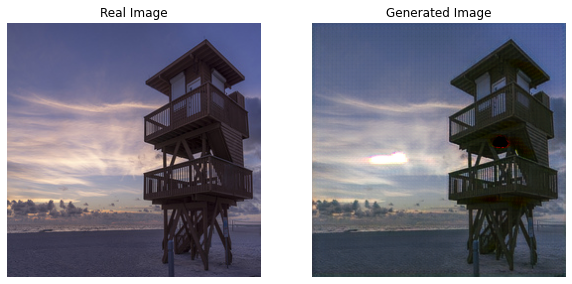

In [ ]:
generate_sample(g_model_BtoA, dataset_B)